# Adherence to Linguistic Laws

We apply analysis covered in the paper "Linguistic laws meet protein sequences: A comparative analysis of subword tokenization methods".

We examined how different tokenization methods conform to key linguistic laws, specifically Zipf’s law and Brevity law.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm
import pickle
from pandarallel import pandarallel
from time import time
from tokenizers import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import linregress
from EfficientBPE.vocabulary_functions import load_tokenizers

In [2]:
pandarallel.initialize(nb_workers=20, progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Load Datasets

In [3]:
# Connect to DB
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

uniref_id = "50"
df_protein = pd.read_sql(f"""SELECT Entry as uniprot_id, Sequence as sequence
                          FROM proteins
                          WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)""", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 3000]

df_protein_sliced = pd.read_sql(f"SELECT uniprot_id, sequence FROM uniref{uniref_id}_domain_sliced_plddt70", conn)
df_protein_sliced = df_protein_sliced[df_protein_sliced['uniprot_id'].isin(df_protein['uniprot_id'])].reset_index(drop=True)

conn.close()

## Load Tokenizers

In [4]:
# 'dataset': {'uniref50', 'uniref90'}
# 'is_pretokenizer': {True, False}
# 'subs_matrix': {'blosum45', 'blosum62', 'pam70', 'pam250'}
# 'mutation_cutoff': {0.7, 0.8, 0.9}
# 'min_mutation_freq': {0, 0.05,. 0.005}
# 'min_mutation_len': {3}
# 'max_mutation_len': {12}
# 'vocab_size': list=[800, 1600, 3200, 6400, 12800, 25600, 51200]

vocab_sizes = [800, 1600, 3200, 6400, 12800, 25600]
uniref_id = "50"

tokenizer_opts_list = [
    {
        'is_mut': False,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': True,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': True,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
]

In [5]:
tokenizer_list = load_tokenizers(tokenizer_opts_list, 'hf')
inner_vocab_list = load_tokenizers(tokenizer_opts_list, 'vocab')

vocab_list = {}
for name, tokenizer in tokenizer_list.items():
    vocab_list[name] = list(set([token for token, idx in tokenizer.get_vocab().items()]))

In [26]:
methods = [method_name[:-len(str(vocab_sizes[0]))-1] for method_name in list(tokenizer_list.keys())[::len(vocab_sizes)]]
methods2names = {mn:mn.replace('mut', 'evo').replace('std', '').replace('blosum', 'BLOSUM').replace('pam', 'PAM').replace('pre', 'Pre') for mn in methods}
methods2names = {k: ' '.join(v.split()[:-2]) if 'evoBPE' in v else v for k, v in methods2names.items()}
methods2names

{'stdBPE': 'BPE',
 'mutBPE blosum62 0.7 0.05': 'evoBPE BLOSUM62',
 'mutBPE pam70 0.7 0.05': 'evoBPE PAM70',
 'mutBPE pre blosum62 0.7 0.05': 'evoBPE Pre BLOSUM62',
 'mutBPE pre pam70 0.7 0.05': 'evoBPE Pre PAM70'}

## Apply Tokenizers to Data

In [27]:
for name, tokenizer in tqdm(list(tokenizer_list.items())):
    if 'pre' in name:
        df_protein_sliced[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein_sliced['sequence'])]
    else:
        df_protein[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein['sequence'])]

100%|██████████| 30/30 [01:30<00:00,  3.01s/it]


In [28]:
df_protein_sliced = df_protein_sliced.groupby('uniprot_id').sum().reset_index()
df_protein = df_protein.set_index(['uniprot_id', 'sequence']).join(df_protein_sliced.set_index(['uniprot_id', 'sequence'])).reset_index()
df_protein.head()

,uniprot_id,sequence,stdBPE 800,stdBPE 1600,stdBPE 3200,stdBPE 6400,stdBPE 12800,stdBPE 25600,mutBPE blosum62 0.7 0.05 800,mutBPE blosum62 0.7 0.05 1600,...,mutBPE pre blosum62 0.7 0.05 3200,mutBPE pre blosum62 0.7 0.05 6400,mutBPE pre blosum62 0.7 0.05 12800,mutBPE pre blosum62 0.7 0.05 25600,mutBPE pre pam70 0.7 0.05 800,mutBPE pre pam70 0.7 0.05 1600,mutBPE pre pam70 0.7 0.05 3200,mutBPE pre pam70 0.7 0.05 6400,mutBPE pre pam70 0.7 0.05 12800,mutBPE pre pam70 0.7 0.05 25600
0,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS,"[M, EL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, P...","[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, REKL, QR, DL, EA, EH, VL, PSP, ...","[MEL, SA, EYL, REKL, QR, DLEA, EH, VL, PSP, GG...","[MEL, SA, EYL, REKL, QR, DLEA, EHVL, PSP, GGVG...","[MEL, SA, EYL, REKL, QR, DLEA, EHVL, PSP, GGVG...","[M, EL, SA, E, YL, R, EKL, QR, DL, EA, EH, VL,...","[M, EL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, P...",...,"[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GG, ...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG...","[M, EL, SA, E, YL, R, EKL, QR, DL, EA, EH, VL,...","[M, EL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, P...","[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, REKL, QRDL, EA, EH, VL, PSP, GG...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG..."
1,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,"[M, GL, EAL, V, PLA, MI, VA, IF, LLL, V, DL, M...","[MGL, EAL, V, PLA, MI, VA, IF, LLL, V, DL, MH,...","[MGL, EAL, V, PLA, MI, VA, IF, LLLV, DL, MH, R...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...","[M, GL, EAL, V, PL, A, MI, VA, IF, LLL, V, DL,...","[M, GL, EAL, V, PL, AMI, VA, IF, LLLV, DLM, H,...",...,"[MGL, EAL, V, PL, AMI, VA, IF, LLLV, DLM, HRH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...","[M, GL, EAL, V, PL, A, MI, VA, IF, LLL, V, DL,...","[MGL, EAL, V, PL, AMI, VA, IF, LLLV, DL, MH, R...","[MGL, EAL, V, PL, AMI, VA, IF, LLLV, DL, MH, R...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,...","[MGL, EALV, PL, AMI, VA, IF, LLLV, DL, MH, RH,..."
2,A0A087X296,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,"[M, SR, S, LLL, W, FLL, FLL, LL, PPL, PV, LL, ...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PV, LL, AD, ...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, W, FLL, FLLLL, PPL, PVLL, AD, PGA,...","[M, SR, S, LLL, W, F, LL, F, LL, LL, PPL, PV, ...","[M, SR, S, LLL, W, FLL, FLL, LL, PPL, PV, LL, ...",...,"[M, SR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, ...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P...","[MSR, SLLL, WFLL, FLLLL, PPL, PVLL, AD, PGA, P...","[M, SR, S, LLL, W, FLL, FLL, LL, PPL, PV, LL, ...","[M, SR, SLLL, W, FLL, FLL, LL, PPL, PV, LL, AD...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PV, LL, AD, ...","[MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,...","[MSR, SLLL, WFLL, FLL, LL, PPL, PVLL, AD, PGA,..."
3,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,"[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GGV, Y...","[M, FR, RLT, FA, QLL, FA, T, VLG, IA, GGV, YI,...","[M, FR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, F...","[MFR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, FQ,...","[MFR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, FQ,...","[MFR, RLT, FA, QLL, FAT, VLG, IA, GGV, YI, FQ,...","[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GG, V,...","[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GGV, Y...",...,"[M, FR, RL, T, FA, QLL, FAT, V

## Configs for the plots

In [29]:
sns.set()
sns.color_palette("Spectral", as_cmap=True)

colors = ['olivedrab', 'lightseagreen', 'slateblue', 'gold', 'cornflowerblue', 'darkred', 'darkorange']
markers = ["o--", "d--", "*--", "X--", "P--", "p--"]
linestyles = ['-', '--', '-.', ':', "."]

label_pad = 6
title_pad = 15
title_size = 16
tick_size = 14

plt.rcParams["figure.figsize"] = (8, 8)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=19)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=13)
plt.rcParams['figure.dpi'] = 100

figures_folder_name = 'figures'

## Shared Token Percentages

Shared token percentages offer insight into segmentation consistency.

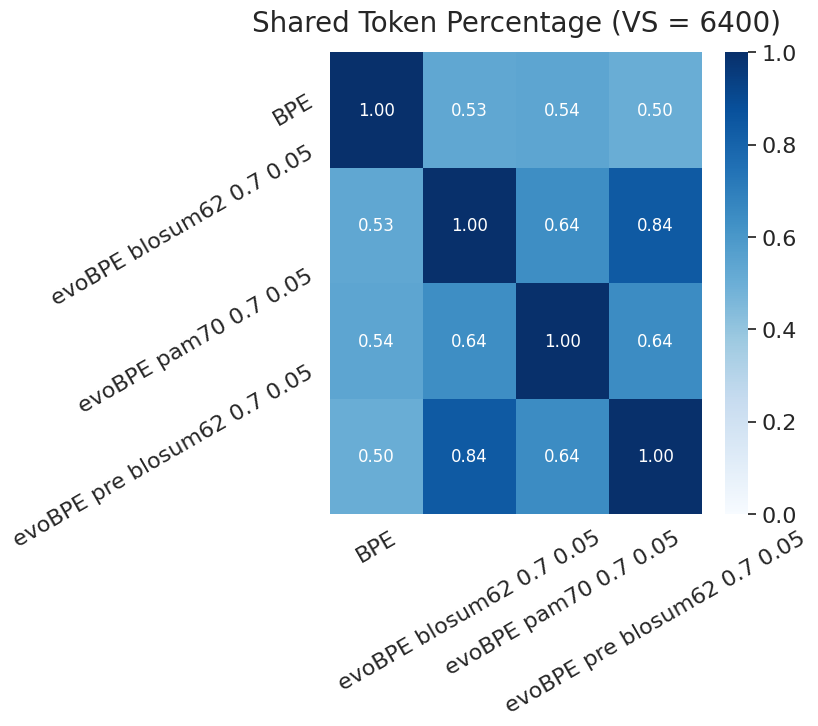

In [11]:
vocab_size = 6400
comp_tokenizers_list =  [f"{method} {vocab_size}" for method in methods]
comp_labels = list(methods2names.values())

data = np.array(np.zeros((len(methods),len(methods))))
for i in range(len(comp_tokenizers_list)):
    for j in range(i, len(comp_tokenizers_list)):
        data[i][j] = len(set(vocab_list[comp_tokenizers_list[i]]).intersection(set(vocab_list[comp_tokenizers_list[j]])))
        data[i][j] /= min(len(vocab_list[comp_tokenizers_list[i]]), len(vocab_list[comp_tokenizers_list[j]]))
        data[j][i] = data[i][j]
# data = data.astype(int)

fig,ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)

sns.heatmap(data, annot = True, fmt='.2f', xticklabels=comp_labels, yticklabels=comp_labels, vmax=1, vmin=0, cmap='Blues')
plt.yticks(rotation=30)
plt.xticks(rotation=30)

plt.title(f"Shared Token Percentage (VS = {vocab_size})", pad=title_pad)

# plt.savefig(f'{figures_folder_name}/shared_token_percent_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/shared_token_percent_{vocab_size}.png', bbox_inches='tight')
plt.show()

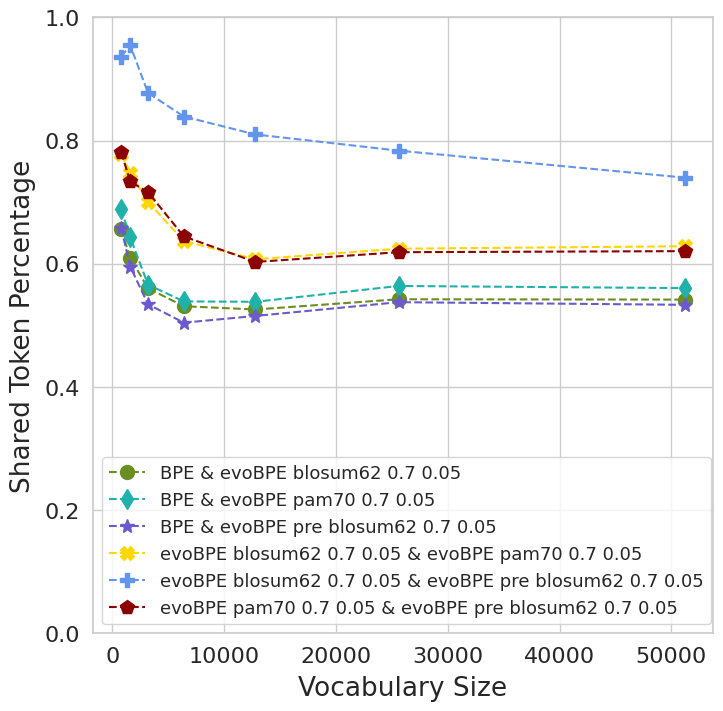

In [12]:
sns.set_style("whitegrid")
for i, (method1, method2) in enumerate([(m1, m2) for j, m1 in enumerate(methods) for _, m2 in enumerate(methods[j+1:])]):
    shared_token_percs = []
    for vocab_size in vocab_sizes:
        tokenizer1 = f'{method1} {vocab_size}'
        tokenizer2 = f'{method2} {vocab_size}'
        shared_token_percs.append(len(set(vocab_list[tokenizer1]).intersection(set(vocab_list[tokenizer2]))))
        shared_token_percs[-1] /= min(len(vocab_list[tokenizer1]), len(vocab_list[tokenizer2]))
    plt.plot(vocab_sizes, shared_token_percs, markers[i], color=colors[i], markersize=10, label=f'{methods2names[method1]} & {methods2names[method2]}')


# plt.title(f"Shared Token Percentage Change of Vocab Sizes Between BPE and WordPiece", pad=title_pad, size=13)
plt.legend()
plt.ylim(top=1, bottom=0)
plt.xticks()
plt.yticks()
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Shared Token Percentage", labelpad=label_pad);
# plt.savefig(f'{figures_folder_name}/shared_token_percent_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/shared_token_percent_plot.png', bbox_inches='tight')
plt.show()

## Token Length Distribution

Token length distribution reflects the granularity of the segmentation.

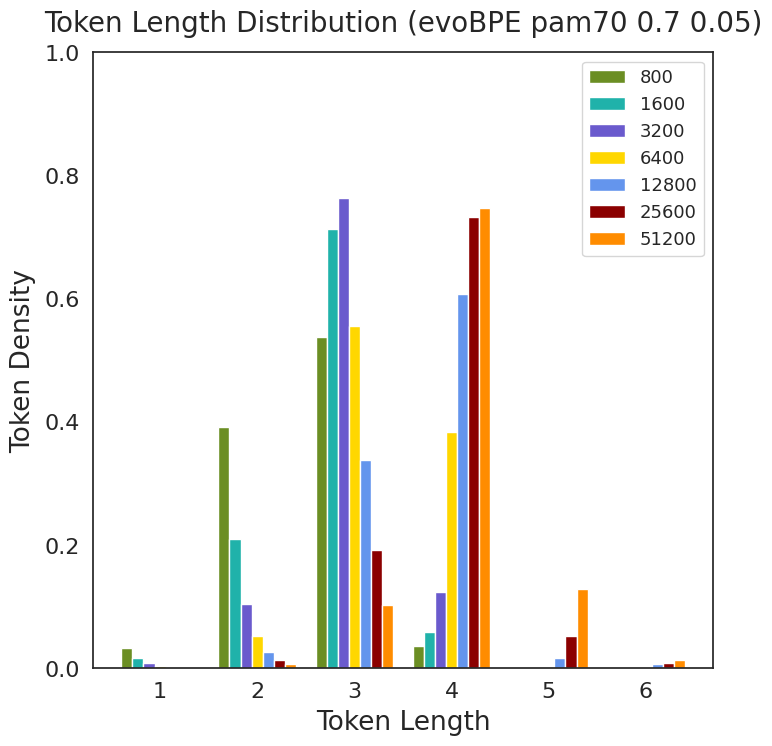

In [13]:
sns.set_style("white")

method = methods[2]
comp_tokenizers_list = [f"{method} {vocab_size}" for vocab_size in vocab_sizes]

a = plt.hist([[len(token) for token in vocab_list[name]] for name in comp_tokenizers_list], [0.5,1.5,2.5,3.5,4.5,5.5,6.5], histtype='bar', label=vocab_sizes, density=True, color=colors[:len(vocab_sizes)])

plt.title(f"Token Length Distribution ({methods2names[method]})", pad=title_pad)
plt.xlabel("Token Length", labelpad=label_pad)
plt.ylabel("Token Density", labelpad=label_pad)
plt.ylim((0,1))
plt.legend()
# plt.savefig(f'{figures_folder_name}/token_length_dist_{method}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/token_length_dist_{method}.png', bbox_inches='tight')
plt.show()

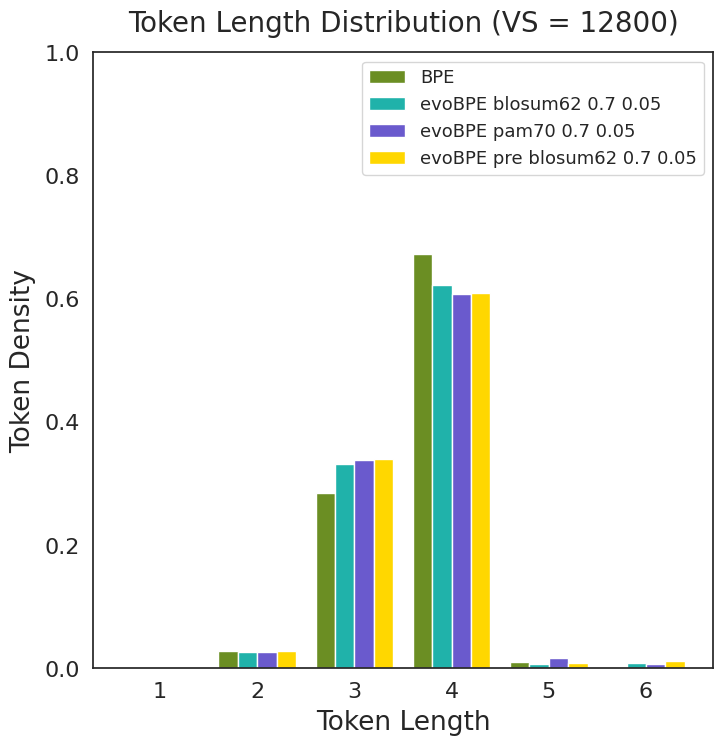

In [14]:
sns.set_style("white")

vocab_size = vocab_sizes[4]
comp_tokenizers_list = [f"{method} {vocab_size}" for method in methods]
comp_labels_list = [methods2names[method] for method in methods]

plt.hist([[len(token) for token in vocab_list[name]] for name in comp_tokenizers_list], [0.5,1.5,2.5,3.5,4.5,5.5,6.5], histtype='bar', label=comp_labels_list, density=True, color=colors[:len(methods)])

plt.title(f"Token Length Distribution (VS = {vocab_size})", pad=title_pad)
plt.xlabel("Token Length", labelpad=label_pad)
plt.ylabel("Token Density", labelpad=label_pad)
plt.ylim((0,1))
plt.legend()
# plt.savefig(f'{figures_folder_name}/token_length_dist_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/token_length_dist_{vocab_size}.png', bbox_inches='tight')
plt.show()

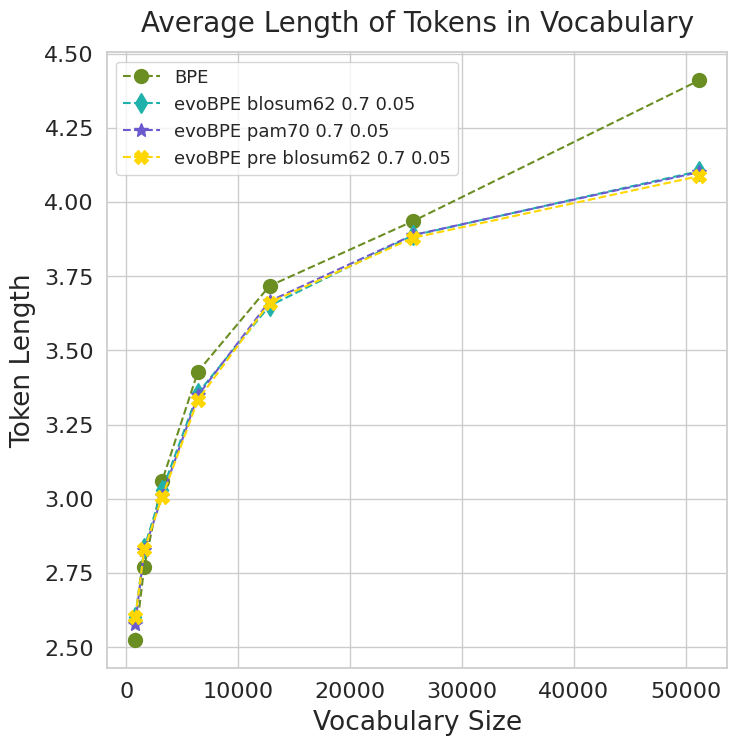

In [15]:
sns.set_style("whitegrid")
for i, method in enumerate(methods):
    plt.plot(vocab_sizes, [np.mean([len(token) for token in vocab_list[f'{method} {vocab_size}']]) for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=methods2names[method])

plt.title(f"Average Length of Tokens in Vocabulary", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Token Length", labelpad=label_pad)
plt.legend()

# plt.xlim([0, 2000])
# plt.ylim([2.0, 4])

# plt.savefig(f'{figures_folder_name}/token_length_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/token_length_plot.png', bbox_inches='tight')

plt.show()

In [16]:
{name: np.mean([len(token) for token in vocab]) for name, vocab in vocab_list.items()}

{'stdBPE 800': np.float64(2.5225),
 'stdBPE 1600': np.float64(2.77125),
 'stdBPE 3200': np.float64(3.0609375),
 'stdBPE 6400': np.float64(3.42875),
 'stdBPE 12800': np.float64(3.71734375),
 'stdBPE 25600': np.float64(3.935),
 'stdBPE 51200': np.float64(4.40966796875),
 'mutBPE blosum62 0.7 0.05 800': np.float64(2.60125),
 'mutBPE blosum62 0.7 0.05 1600': np.float64(2.835625),
 'mutBPE blosum62 0.7 0.05 3200': np.float64(3.0284375),
 'mutBPE blosum62 0.7 0.05 6400': np.float64(3.3565625),
 'mutBPE blosum62 0.7 0.05 12800': np.float64(3.650234375),
 'mutBPE blosum62 0.7 0.05 25600': np.float64(3.887265625),
 'mutBPE blosum62 0.7 0.05 51200': np.float64(4.103968129979691),
 'mutBPE pam70 0.7 0.05 800': np.float64(2.57875),
 'mutBPE pam70 0.7 0.05 1600': np.float64(2.826875),
 'mutBPE pam70 0.7 0.05 3200': np.float64(3.00875),
 'mutBPE pam70 0.7 0.05 6400': np.float64(3.3484375),
 'mutBPE pam70 0.7 0.05 12800': np.float64(3.665859375),
 'mutBPE pam70 0.7 0.05 25600': np.float64(3.888476562

In [17]:
test_average_token_lenghts = {name: np.mean(df_protein[name].apply(lambda xx: np.mean([len(x) for x in xx]))) for name in list(vocab_list.keys())}

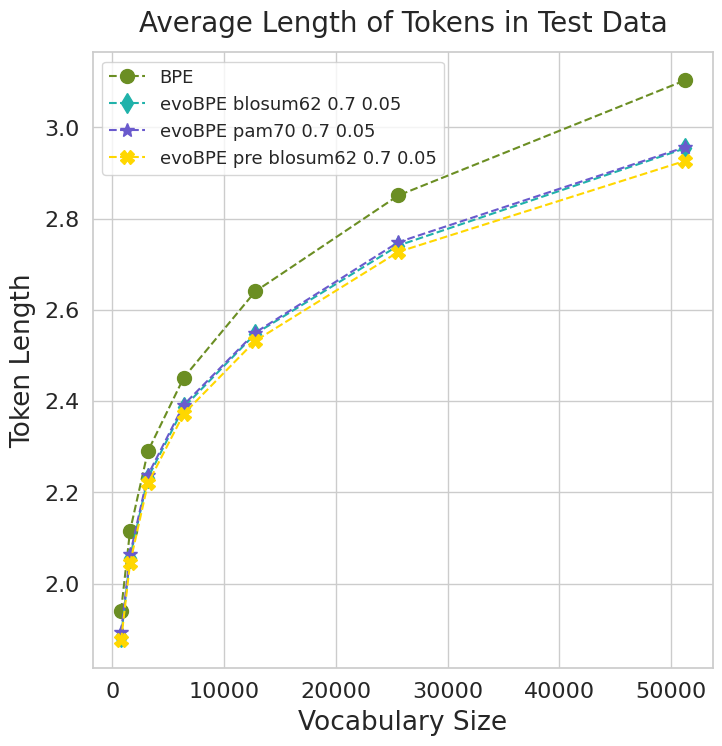

In [18]:
sns.set_style("whitegrid")

for i, method in enumerate(methods):
    plt.plot(vocab_sizes, [test_average_token_lenghts[f'{method} {vocab_size}'] for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=methods2names[method])

plt.title(f"Average Length of Tokens in Test Data", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Token Length", labelpad=label_pad)
plt.legend()

# plt.ylim([1.7, 2.8])

# plt.savefig(f'{figures_folder_name}/token_length_test_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/token_length_test_plot.png', bbox_inches='tight')

plt.show()

In [19]:
test_average_token_lenghts

{'stdBPE 800': np.float64(1.9408007665334068),
 'stdBPE 1600': np.float64(2.115688669567353),
 'stdBPE 3200': np.float64(2.290302731990621),
 'stdBPE 6400': np.float64(2.4513112362735665),
 'stdBPE 12800': np.float64(2.640287172558751),
 'stdBPE 25600': np.float64(2.850711531360694),
 'stdBPE 51200': np.float64(3.10256666640011),
 'mutBPE blosum62 0.7 0.05 800': np.float64(1.882753314681787),
 'mutBPE blosum62 0.7 0.05 1600': np.float64(2.0571513876338074),
 'mutBPE blosum62 0.7 0.05 3200': np.float64(2.231948780090188),
 'mutBPE blosum62 0.7 0.05 6400': np.float64(2.386373583579958),
 'mutBPE blosum62 0.7 0.05 12800': np.float64(2.5475605191938384),
 'mutBPE blosum62 0.7 0.05 25600': np.float64(2.7409778596650347),
 'mutBPE blosum62 0.7 0.05 51200': np.float64(2.953633659309946),
 'mutBPE pam70 0.7 0.05 800': np.float64(1.8936379378416246),
 'mutBPE pam70 0.7 0.05 1600': np.float64(2.064133511357072),
 'mutBPE pam70 0.7 0.05 3200': np.float64(2.238063723869004),
 'mutBPE pam70 0.7 0.0

## Fertility

Fertility, the average number of tokens required to represent a protein sequence, indicates encoding efficiency.

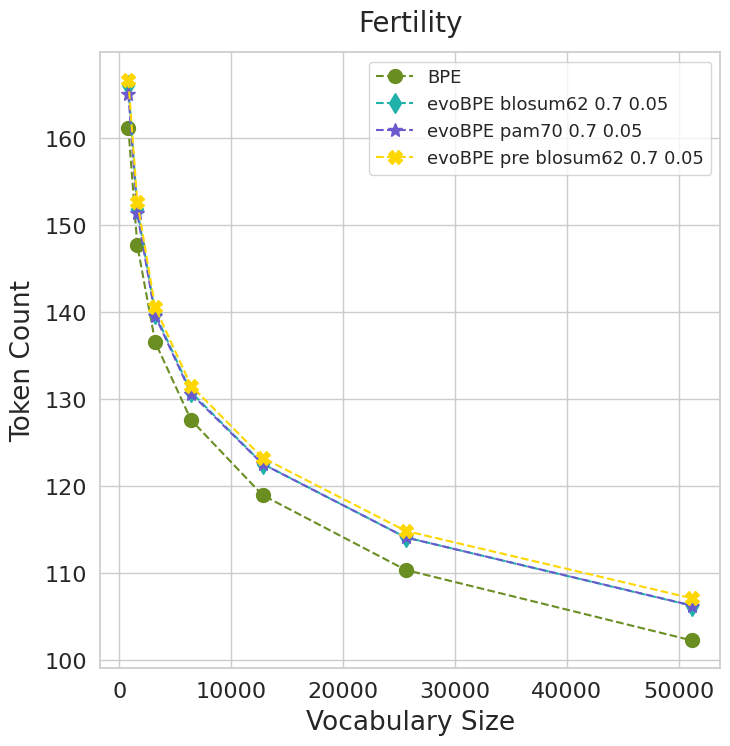

In [20]:
sns.set_style("whitegrid")
for i, method in enumerate(methods):
    plt.plot(vocab_sizes, [df_protein[f'{method} {vocab_size}'].apply(len).mean() for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=methods2names[method])

plt.title(f"Fertility", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Token Count", labelpad=label_pad)
plt.legend()

# plt.savefig(f'{figures_folder_name}/fertility_plot.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/fertility_plot.png', bbox_inches='tight')

plt.show()

## Contextual Exponence

Contextual exponence, the diversity of neighboring tokens each token encounters, sheds light on semantic relationships.

In [21]:
token_neighs = {}

window_size = 2
for name in tqdm(vocab_list.keys()):
    temp_neighs = {}
    for seq in df_protein[name]:
        for i, tok in enumerate(seq):
            if tok not in temp_neighs:
                temp_neighs[tok] = []
            temp_neighs[tok].extend(seq[max(i-window_size, 0):i])
            temp_neighs[tok].extend(seq[i+1:min(i+window_size+1, len(seq))])
    token_neighs[name] = temp_neighs
    
token_neighs_unq_len = {name: {token: len(set(neighs)) for token, neighs in tokens.items()} for name, tokens in token_neighs.items()}

100%|██████████| 28/28 [02:51<00:00,  6.14s/it]


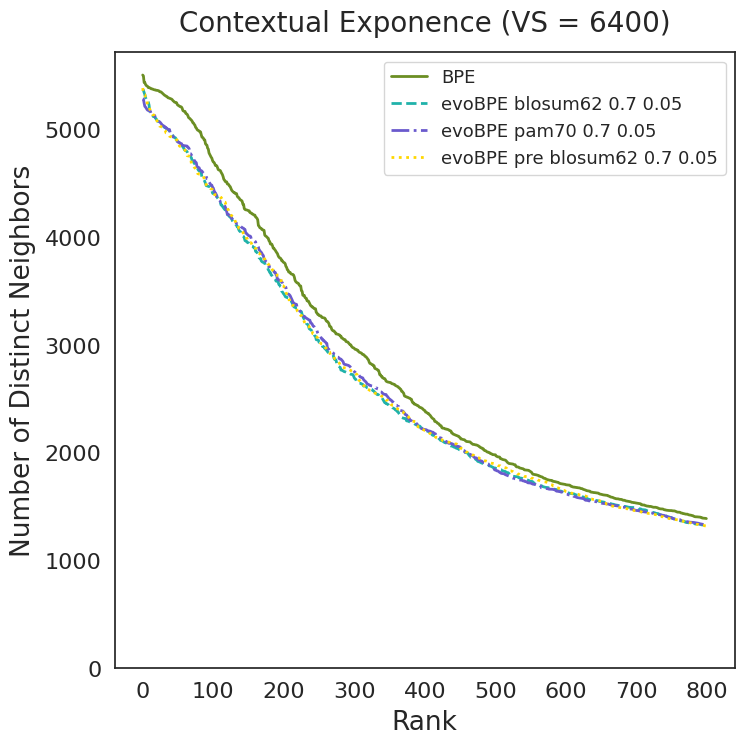

In [22]:
sns.set_style("white")
vocab_size = vocab_sizes[3]

for idx, method in enumerate(methods):
    plt.plot([t[1] for t in sorted(token_neighs_unq_len[f'{method} {vocab_size}'].items(), key=lambda x: -x[1])[:800]], linestyles[idx], linewidth=2, color=colors[idx], label=methods2names[method])

plt.title(f"Contextual Exponence (VS = {vocab_size})", pad=title_pad)
plt.xlabel("Rank", labelpad=label_pad)
plt.ylabel("Number of Distinct Neighbors", labelpad=label_pad)
plt.ylim(0)
# plt.xlim(right = 450)
plt.legend()

# plt.savefig(f'{figures_folder_name}/contextual_exponence_plot_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/contextual_exponence_plot_{vocab_size}.png', bbox_inches='tight')

plt.show()

## Zipf's Law

Zipf's law, the inverse proportionality between token frequency and rank, indicates linguistic regularity.

In [30]:
token_freqs_dict = {}
for tokenizer_name in tqdm(vocab_list.keys()):
    counter_series = df_protein[tokenizer_name].apply(Counter)
    counter_sum = counter_series[0]
    for cs in counter_series[1:]:
        counter_sum.update(cs)
    token_freqs_dict[tokenizer_name] = counter_sum.copy()
    # token_freqs_dict[tokenizer_name] = df_protein[tokenizer_name].apply(Counter).sum().copy()

100%|██████████| 30/30 [01:06<00:00,  2.20s/it]


In [31]:
for tokenizer_name in tqdm(vocab_list.keys()):
    to_del = []
    for k, v in token_freqs_dict[tokenizer_name].items():
        if k not in vocab_list[tokenizer_name]:
            to_del.append(k)
    for k in to_del:
        del token_freqs_dict[tokenizer_name][k]

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


In [32]:
zipf_slopes = {}
for tokenizer_name, token_freqs in token_freqs_dict.items():
    freqs = np.array(list(token_freqs.values()))
    sorted_freqs = np.sort(freqs)[::-1]
    y_data = np.log(sorted_freqs)
    x_data = np.log(np.array(range(1, len(sorted_freqs) + 1)))
    
    x_masked = x_data.copy()
    y_masked = y_data.copy()
    
    zipf_slopes[tokenizer_name] = linregress(x_masked, y_masked).slope

In [33]:
zipf_slopes

{'stdBPE 800': np.float64(-1.127170022589619),
 'stdBPE 1600': np.float64(-1.1269985413118955),
 'stdBPE 3200': np.float64(-1.1498604861688333),
 'stdBPE 6400': np.float64(-1.1746051346047015),
 'stdBPE 12800': np.float64(-1.137714786083906),
 'stdBPE 25600': np.float64(-1.0891686119252222),
 'mutBPE blosum62 0.7 0.05 800': np.float64(-1.3477137967575639),
 'mutBPE blosum62 0.7 0.05 1600': np.float64(-1.3172287095145507),
 'mutBPE blosum62 0.7 0.05 3200': np.float64(-1.312940569906418),
 'mutBPE blosum62 0.7 0.05 6400': np.float64(-1.3747429841807293),
 'mutBPE blosum62 0.7 0.05 12800': np.float64(-1.3772259579851445),
 'mutBPE blosum62 0.7 0.05 25600': np.float64(-1.3383904315466297),
 'mutBPE pam70 0.7 0.05 800': np.float64(-1.2959243427962959),
 'mutBPE pam70 0.7 0.05 1600': np.float64(-1.2911022376273342),
 'mutBPE pam70 0.7 0.05 3200': np.float64(-1.3006307508927093),
 'mutBPE pam70 0.7 0.05 6400': np.float64(-1.3619651051566273),
 'mutBPE pam70 0.7 0.05 12800': np.float64(-1.3711

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


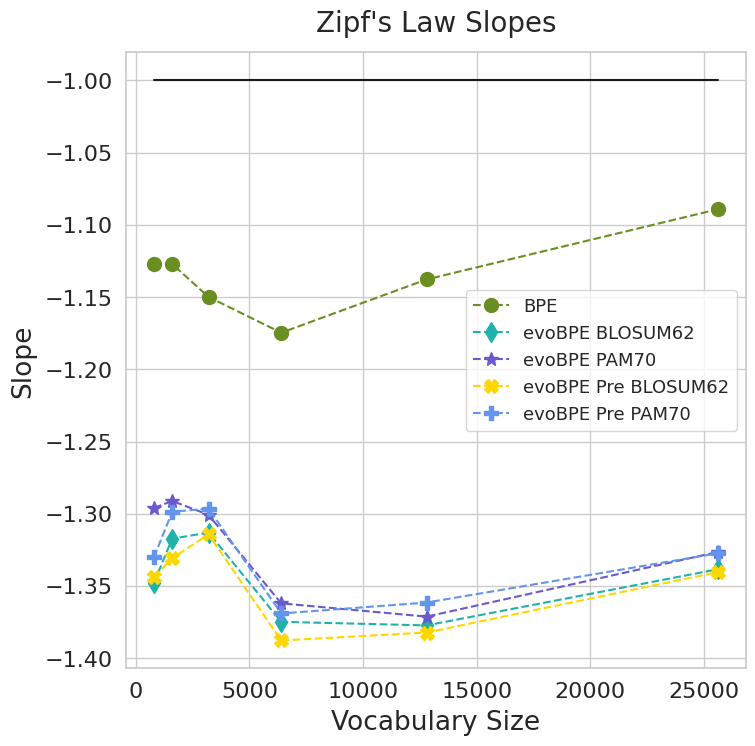

In [35]:
sns.set_style("whitegrid")

plt.plot(vocab_sizes, [-1 for _ in vocab_sizes], 'k-')

for i, method in enumerate(methods):
    plt.plot(vocab_sizes, [zipf_slopes[f'{method} {vocab_size}'] for vocab_size in vocab_sizes], markers[i], color=colors[i], markersize=10, label=methods2names[method])

plt.title(f"Zipf's Law Slopes", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Slope", labelpad=label_pad)
plt.legend()

plt.savefig(f'{figures_folder_name}/zipf_slope_plot.eps', bbox_inches='tight')
plt.savefig(f'{figures_folder_name}/zipf_slope_plot.pdf', bbox_inches='tight')
plt.savefig(f'{figures_folder_name}/zipf_slope_plot.png', bbox_inches='tight')

plt.show()

### Analysis

To see if Zipf's Law holds for our tokenization methods, we plotted token frequency against rank on a log-log scale, where an ideal Zipfian distribution would have a slope of -1. BPE followed this pattern more closely than evoBPE. The reason for evoBPE’s slight deviation lies in how it changes the token frequency distribution. However, even though evoBPE introduces low-frequency mutation tokens, its Zipf’s law plot didn’t show extreme divergence, meaning our approach remains stable.

## Brevity Law

Brevity law is the tendency of frequently used tokens to be shorter.

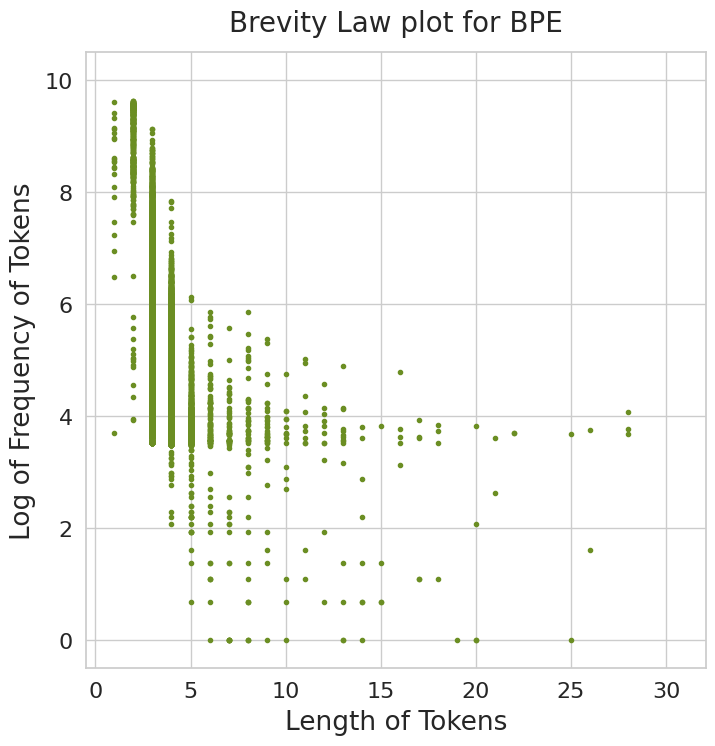

In [ ]:
sns.set_style("whitegrid")
thr = 32
vocab_size = vocab_sizes[5]
i = 0
method = methods[i]
tokenizer_name = f'{method} {vocab_size}'
token_freqs = token_freqs_dict[tokenizer_name]

freqs = np.array(list(token_freqs.values()))
lengths = np.array([len(token) for token in list(token_freqs.keys())])

# plt.plot(lengths, np.log(freqs), ".", color=colors[i])
# plt.plot(lengths[freqs > 10], np.log(freqs[freqs > 10]), ".", color=colors[i])
plt.plot(lengths[lengths < thr], np.log(freqs[lengths < thr]), ".", color=colors[i])

lf_df = pd.DataFrame([lengths, freqs]).T
lf_df = lf_df.rename(columns={0:'lengths', 1:'freqs'})
# lf_df['lengths'] = lf_df['lengths'].astype(int)
# lf_df = lf_df[lf_df['freqs'] > 0]
# lf_mean = lf_df.groupby('lengths')['freqs'].mean()
# # lf_mean = lf_mean[lf_mean.index < 70]
# plt.plot(lf_mean.index, np.log(lf_mean), markers[0], markersize=10, color=colors[i])

plt.title(f"Brevity Law plot for {methods2names[method]}", pad=title_pad)
plt.ylim(bottom=-0.5, top=10.5)
plt.xlim(left=-0.5, right=thr+.1)
plt.xlabel("Length of Tokens", labelpad=label_pad)
plt.ylabel("Log of Frequency of Tokens", labelpad=label_pad)
plt.savefig(f'{figures_folder_name}/brevity_{tokenizer_name}_{thr}.eps', bbox_inches='tight')
plt.savefig(f'{figures_folder_name}/brevity_{tokenizer_name}_{thr}.pdf', bbox_inches='tight')
plt.savefig(f'{figures_folder_name}/brevity_{tokenizer_name}_{thr}.png', bbox_inches='tight')
plt.show()

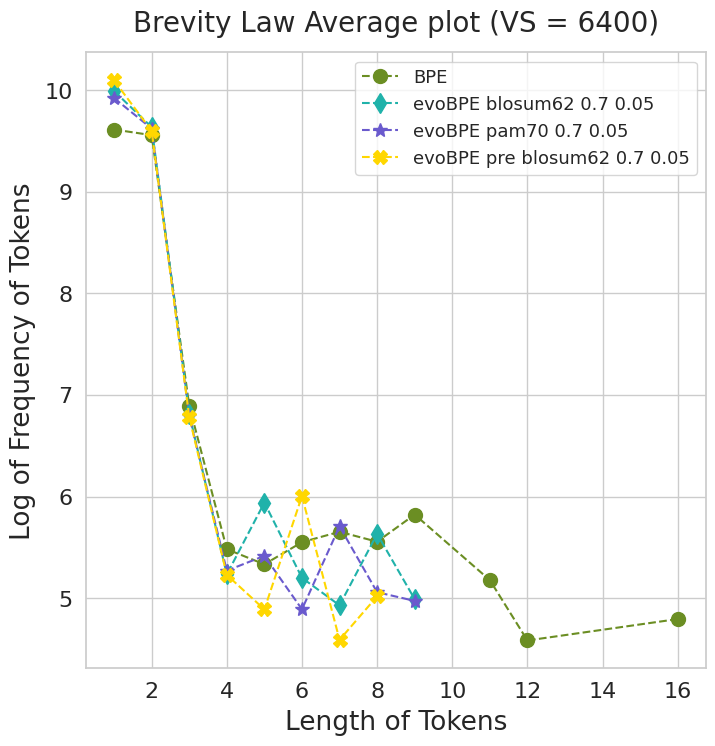

In [72]:
vocab_size = vocab_sizes[3]
for idx, method in enumerate(methods):
    tokenizer_name = f'{method} {vocab_size}'
    token_freqs = token_freqs_dict[tokenizer_name]

    freqs = np.array(list(token_freqs.values()))
    lengths = np.array([len(token) for token in list(token_freqs.keys())])

    lf_df = pd.DataFrame([lengths, freqs]).T
    lf_df = lf_df.rename(columns={0:'lengths', 1:'freqs'})
    lf_df['lengths'] = lf_df['lengths'].astype(int)
    lf_mean = lf_df.groupby('lengths')['freqs'].mean()
    lf_mean = lf_mean[lf_mean.index < 70]
    plt.plot(lf_mean.index, np.log(lf_mean), markers[idx], color=colors[idx], markersize=10, label=methods2names[method])

plt.title(f"Brevity Law Average plot (VS = {vocab_size})", pad=title_pad)
# plt.ylim(bottom=0, top=11)
# plt.xlim(left=0, right=17)
plt.xlabel("Length of Tokens", labelpad=label_pad)
plt.ylabel("Log of Frequency of Tokens", labelpad=label_pad)
plt.legend()
# plt.savefig(f'{figures_folder_name}/brevity_avg_{vocab_size}.pdf', bbox_inches='tight')
# plt.savefig(f'{figures_folder_name}/brevity_avg_{vocab_size}.png', bbox_inches='tight')
plt.show()

### Analysis

When we looked at token length distributions, we saw that evoBPE, with its mutation-based tokens, leaned toward slightly shorter tokens, whereas BPE produced a more balanced token length distribution. This doesn’t mean evoBPE breaks Brevity law—rather, it shows how BPE takes a more uniform approach to token length.